In [1]:
import pandas as pd
# contains folders locations and all
from setup import *
from cells_detection.detection_model import *
from mrcnn.visualize import display_images,draw_boxes
from mrcnn.model import log
import skimage.color


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Root directory /users/nfs/Etu7/21113797/PRAT/mrcnn


In [16]:

def extract_image_features(image_id, model, config, dataset, feature_size=64):

    image = dataset.load_image(image_id)

    mrcnn = model.run_graph([image], [
        # backbone output
        ("res4f_out", model.keras_model.get_layer("res4f_out").output),  #
        ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ])

    # (1024, 88, 140)
    activations = np.transpose(mrcnn["res4f_out"][0, :, :, :], [2, 0, 1])

    # resize activations

    activations = np.array([np.squeeze(utils.resize_image(
        np.expand_dims(activ_map, -1),
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)[0]) for activ_map in activations])

    nb_detections = mrcnn['detections'][0, :, 4].astype(np.int32).sum()

    detected_boxes = utils.denorm_boxes(
        mrcnn["detections"][0, :nb_detections, :4], activations[0].shape)

    # (nb_objs, nb_features,feature_sizexfeature_size)
    objects_features = np.zeros(
        (nb_detections, len(activations), feature_size**2))

    # for each (88, 140)
    for j in range(len(detected_boxes)):

        y1, x1, y2, x2 = detected_boxes[j]
        x = (feature_size - (x2 - x1)) // 2
        y = (feature_size - (y2 - y1)) // 2

        for i in range(len(activations)):
            # it s one of the activation maps of the image

            object_feature = np.zeros((feature_size, feature_size))

            # Paste the foreground image onto the background image
            object_feature[y:y + (y2 - y1), x:x + (x2 - x1)
                           ] = activations[i][y1:y2, x1:x2]

            objects_features[j, i] = object_feature.ravel()

    # HERE I RETURN THE BOXES FOR THE IMAGE
    image, _, _, _, _ = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    detected_boxes1 = utils.denorm_boxes(
        mrcnn["detections"][0, :nb_detections, :4], (np.squeeze(image).shape[:2]))

    return image, objects_features, detected_boxes,detected_boxes1,activations


In [17]:

DATASET_DIR2 = "Images"

weights = "train_results3/cell20230123T1638/mask_rcnn_cell_0080.h5"

print("Weights: ", weights)
print("Dataset: ", DATASET_DIR2)

config = CellInferenceConfig()
dataset = prepareDataset(DATASET_DIR2,"val1")
# # Create model
model = modellib.MaskRCNN(mode="inference", config=config,
                        model_dir=TEST_SAVE_DIR)

# select weights
model = selectWeights(model, weights)

image_id = dataset.image_ids[0]

image, objects_features, features_boxes, detected_boxes,activations = extract_image_features(image_id, model, config, dataset)

Weights:  train_results3/cell20230123T1638/mask_rcnn_cell_0080.h5
Dataset:  Images
Re-starting from epoch 80
Loading weights  train_results3/cell20230123T1638/mask_rcnn_cell_0080.h5


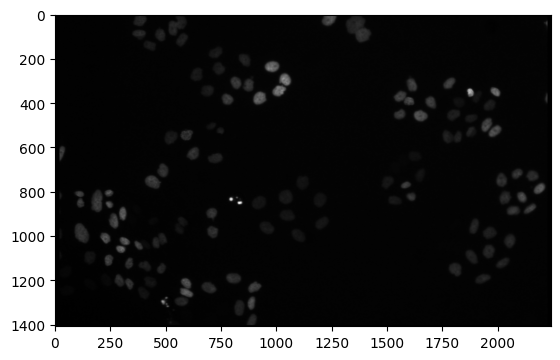

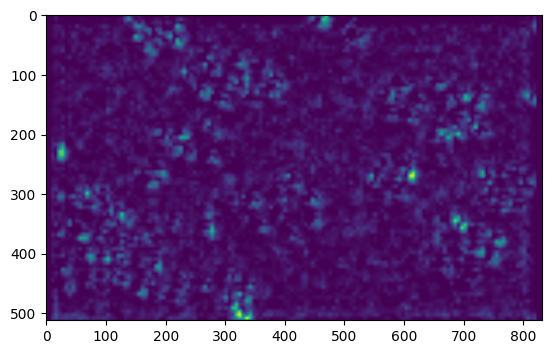

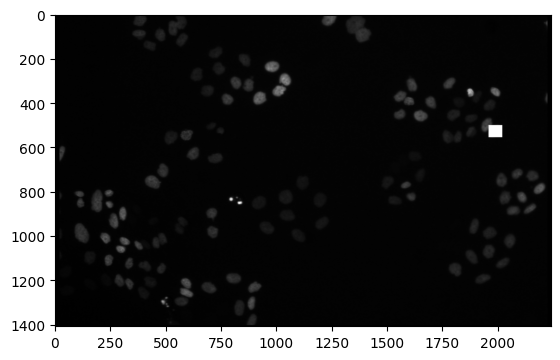

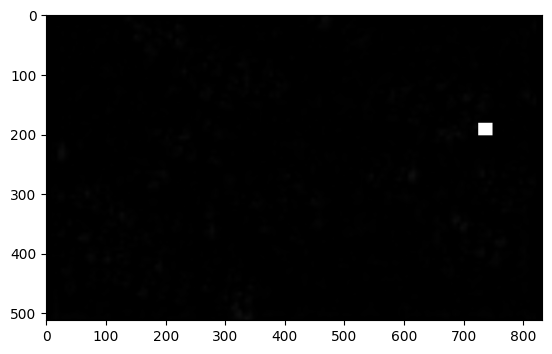

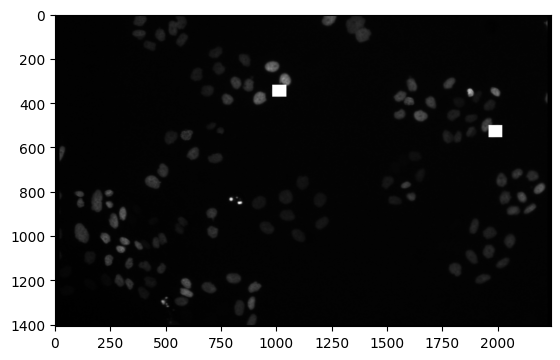

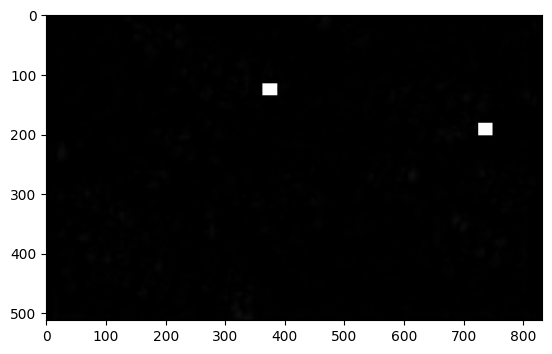

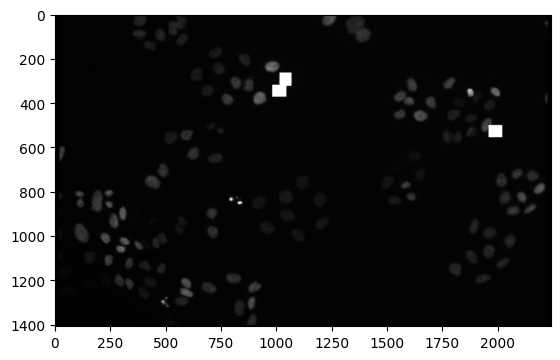

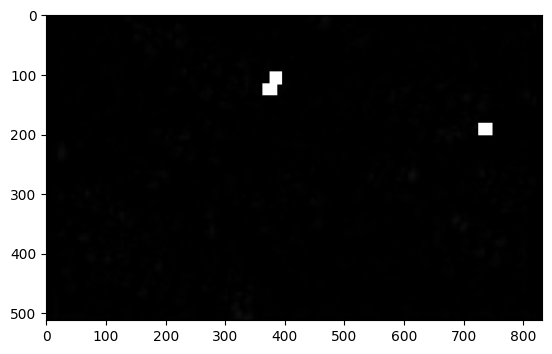

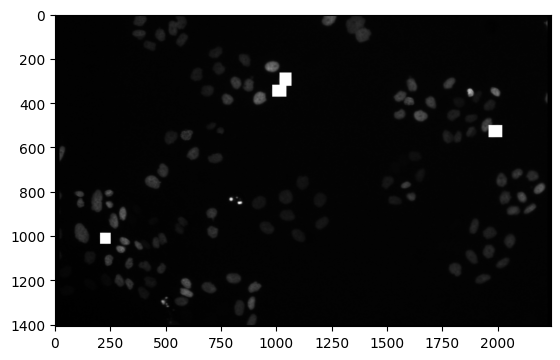

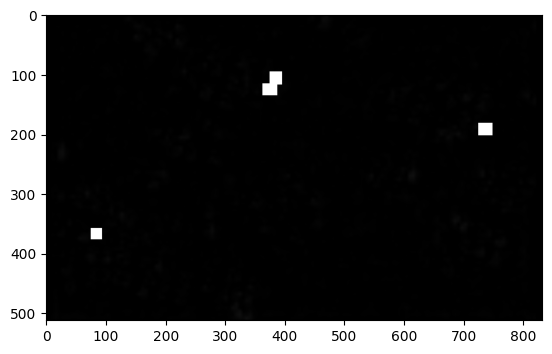

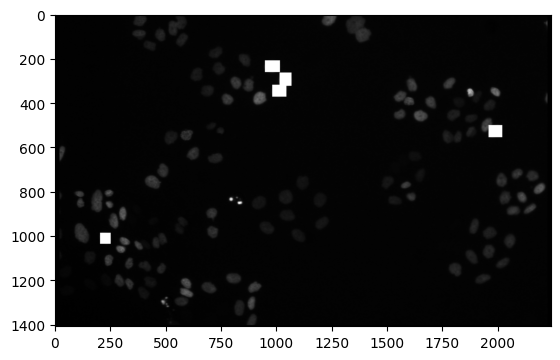

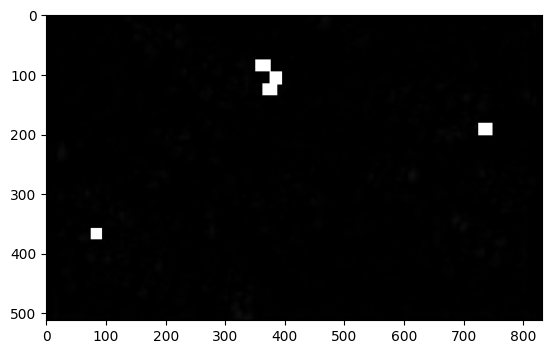

(512, 832)


In [18]:
plt.imshow(image,cmap='gray')

plt.show()
plt.imshow(activations[0])

plt.show()

for i in range(len(detected_boxes[:5])):

    y1, x1, y2, x2 = detected_boxes[i]

    image[y1:y2,x1:x2] = 255
    

    plt.imshow(image)

    plt.show()

    y1, x1, y2, x2 = features_boxes[i]

    activations[0][y1:y2,x1:x2] = 255

    plt.imshow(activations[0],cmap='gray')

    plt.show()

print(activations[0].shape)
    

In [ ]:
DATASET_DIR2 = "Images"

weights = "train_results3/cell20230123T1638/mask_rcnn_cell_0080.h5"

print("Weights: ", weights)
print("Dataset: ", DATASET_DIR2)

# # Configurations

config = CellInferenceConfig()
dataset = prepareDataset(DATASET_DIR2)
# # Create model
model = modellib.MaskRCNN(mode="inference", config=config,
                        model_dir=TEST_SAVE_DIR)

# select weights
model = selectWeights(model, weights)

seq1_size = 2

seq_features = []

seq_boxes = []

seq_images = []

for image_id in dataset.image_ids[:seq1_size]:
    
    print(dataset.image_info[image_id]["id"])

    image,image_features,image_boxes = extract_image_features(image_id, model, config, dataset)

    seq_features+=[image_features]
    seq_boxes+=[image_boxes]

    seq_images+=[image]


Weights:  train_results3/cell20230123T1638/mask_rcnn_cell_0080.h5
Dataset:  Images
Instructions for updating:
Use fn_output_signature instead
Re-starting from epoch 80
Loading weights  train_results3/cell20230123T1638/mask_rcnn_cell_0080.h5
t074
t075


In [ ]:
from scipy.spatial.distance import cdist

def resize_features(features1,features2):

    if len(features1)>len(features2):

        f2_shape = len(features2)

        features2 = np.resize(features2,features1.shape)

        for i in range(f2_shape,len(features1)):

            features2[i] = np.full(features2.shape[-1],10**5)

    return features1,features2

def cost_matrix(features1,features2,metric='euclidean'):

    features1 = features1.reshape(features1.shape[0],-1)

    features2 = features2.reshape(features2.shape[0],-1)

    # check both
    features1,features2 = resize_features(features1,features2)
    features2,features1 = resize_features(features2,features1)

    cost_matrix = cdist(features1,features2,metric)

    return cost_matrix

print(seq_features[0].shape)
print(seq_features[1].shape)
euclidean_matrix = cost_matrix(seq_features[0].copy(),seq_features[1].copy())


(133, 1024, 4096)
(130, 1024, 4096)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132']


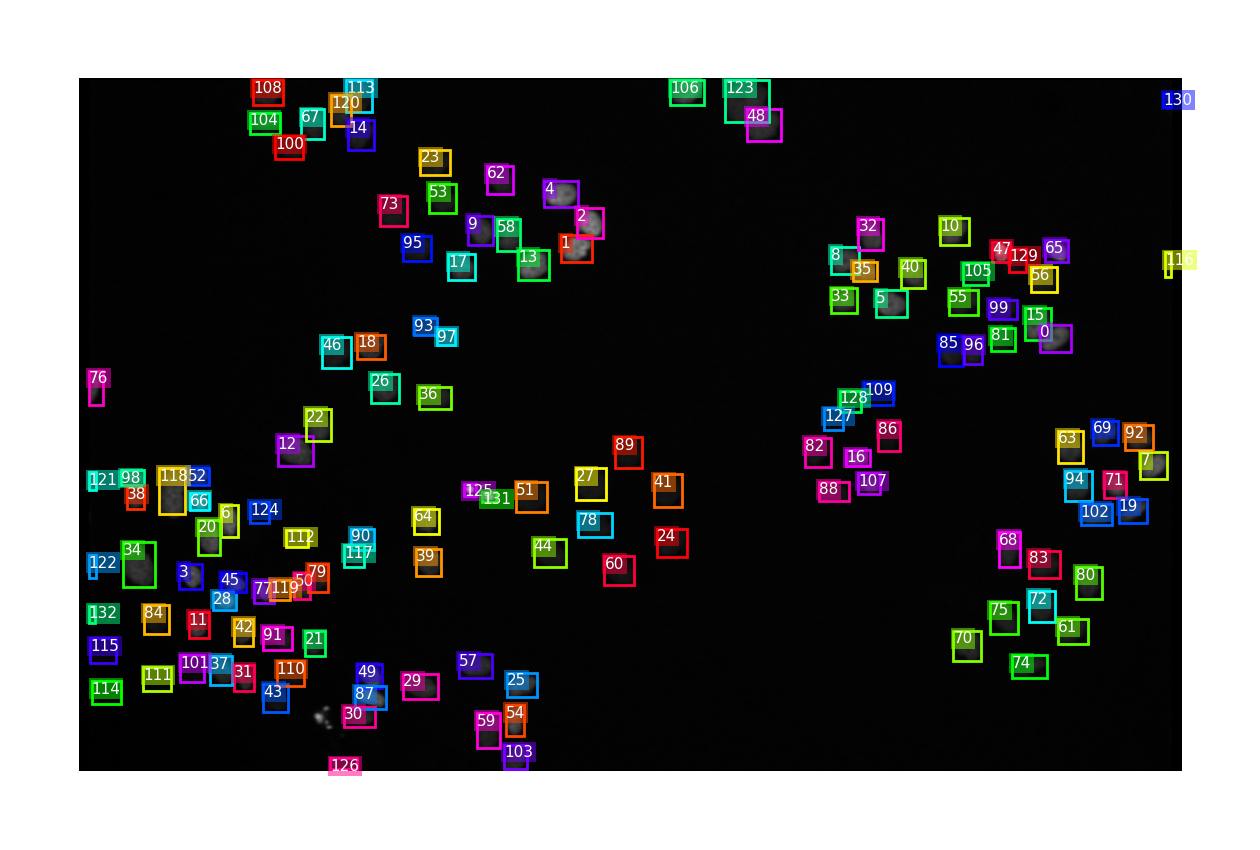

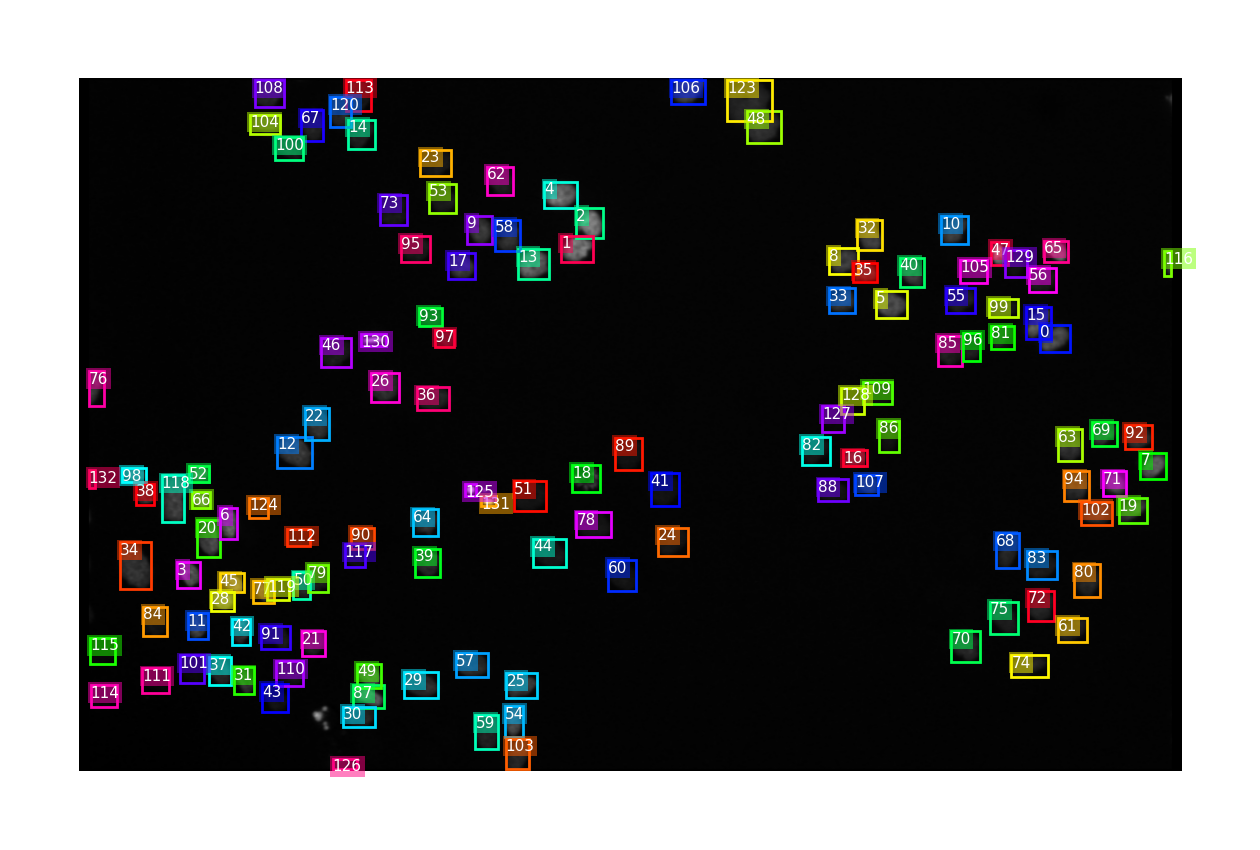

In [ ]:
from scipy.optimize import linear_sum_assignment

id_image1, col_ind = linear_sum_assignment(euclidean_matrix)

id_image2 = np.zeros_like(id_image1)

for i, indice in enumerate(col_ind):

    id_image2[indice]= i

captions1 = list(map(str, id_image1))

print(captions1)
captions2 =list(map(str, id_image2))
draw_boxes(seq_images[0], refined_boxes=seq_boxes[0],captions=captions1,
title="", ax=get_ax())

draw_boxes(seq_images[1], refined_boxes=seq_boxes[1],captions=captions2,
title="", ax=get_ax())

In [ ]:


print("Weights: ", weights)
print("Dataset: ", DATASET_DIR2)

# # Configurations

config = CellInferenceConfig()

# config.display()

dataset = prepareDataset(DATASET_DIR2)

# # Create model
model = modellib.MaskRCNN(mode="inference", config=config,
                            model_dir=TEST_SAVE_DIR)

# select weights
model = selectWeights(model, weights)

# model.keras_model.summary()
image_id = dataset.image_ids[0]


In [ ]:


print(dataset.image_info[image_id]["id"])


# must be loaded this way
image =dataset.load_image(image_id)

print(image.shape)


mrcnn = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4f_out",          model.keras_model.get_layer("res4f_out").output),  #
    # ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    # ("roi",                model.keras_model.get_layer("ROI").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
   
])


In [ ]:
#res4f_out   shape: (1, 88, 140, 1024) 1024 nb feature maps de taille( 8,140)
display_images(np.transpose(mrcnn["res4f_out"][0,:,:,:5], [2, 0, 1]),cmap="gray")

print(np.transpose(mrcnn["res4f_out"][0,:,:,:], [2, 0, 1]).shape)


# features1 = mrcnn["res4f_out"][:,:,:,0]

# print(features1.shape)

# display_images(features1,cmap="gray") 


In [ ]:
# Masks
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]


features1 =  np.squeeze(mrcnn["res4f_out"][:,:,:,0])


features1, _, _, _, _ = utils.resize_image(
        np.expand_dims(features1,-1),
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

features_boxes = utils.denorm_boxes(mrcnn["detections"][0, :det_count, :4], features1.shape[:2])


print(features_boxes.shape)

# it just need some resizing to fit the models inputs 
image =dataset.load_image(image_id)
image, _, _, _, _ = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)




image_boxes =  utils.denorm_boxes(mrcnn["detections"][0, :det_count, :4], (np.squeeze(image).shape[:2]))

draw_boxes(np.squeeze(features1), refined_boxes=features_boxes,
               title="", ax=get_ax())

draw_boxes(image, refined_boxes=image_boxes,
title="", ax=get_ax())

biggest =[]

for box in features_boxes:

    y1, x1, y2, x2 = box

    # features1[y1:y2, x1:x2] = 255

    im_cropped = np.squeeze(features1[y1:y2, x1:x2])

    result = np.zeros((64,64))

    # Calculate the coordinates to paste the foreground image
    x = (64 - im_cropped.shape[1]) // 2
    y = (64 - im_cropped.shape[0]) // 2

    # Paste the foreground image onto the background image
    result[y:y+im_cropped.shape[0], x:x+im_cropped.shape[1]] = im_cropped

    fig = plt.figure()

    ax = fig.add_subplot(1,2,1)
    ax.imshow(im_cropped,cmap="gray")

    ax = fig.add_subplot(1,2,2)
    ax.imshow(result,cmap="gray")

    plt.show()




# print(np.array(biggest).max())
# draw_boxes(np.squeeze(features1), refined_boxes=features_boxes,
#             title="", ax=get_ax())


Tries


In [ ]:
# molded works with load image gt

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(
                    dataset, config, image_id)

# Run object detection
results = model.detect_molded(np.expand_dims(
    image, 0), np.expand_dims(image_meta, 0), verbose=0)


# Display results
r = results[0]

# Display predictions only
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=get_ax(
                                1),
                            show_bbox=True, show_mask=False,
                            title="Predictions")

In [ ]:


print(image_id)
image = dataset.load_image(image_id)

# Run object detection
results = model.detect([image], verbose=0)


# Display results
r = results[0]
print(image.shape)
print(r['rois'].shape)
# Display predictions only
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=get_ax(
                                1),
                            show_bbox=True, show_mask=False,
                            title="Predictions")




In [ ]:
model.keras_model.summary()

In [8]:
from scipy.spatial.distance import cdist

np.random.seed(10)
v1 = np.random.randint(1,10,(4,2))
v2 = np.random.randint(1,10,(5,2))


print(v1)
print(v2)

cdist(v1,v2,"euclidean")

[[5 1]
 [2 1]
 [2 9]
 [1 9]]
[[7 5]
 [4 1]
 [5 7]
 [9 2]
 [9 5]]


array([[ 4.47213595,  1.        ,  6.        ,  4.12310563,  5.65685425],
       [ 6.40312424,  2.        ,  6.70820393,  7.07106781,  8.06225775],
       [ 6.40312424,  8.24621125,  3.60555128,  9.89949494,  8.06225775],
       [ 7.21110255,  8.54400375,  4.47213595, 10.63014581,  8.94427191]])

In [7]:
import numpy as np
from scipy.optimize import linear_sum_assignment

cost_matrix = np.random.randint(1,10,(4,4))
cost_matrix[-1]=100
print(cost_matrix)
row_ind, col_ind = linear_sum_assignment(cost_matrix)


print(row_ind, col_ind)

cost_matrix = cost_matrix[:3,:4]
print(cost_matrix)
row_ind, col_ind = linear_sum_assignment(cost_matrix)


print(row_ind, col_ind)

[[  4   3   7   1]
 [  6   2   4   7]
 [  6   6   2   9]
 [100 100 100 100]]
[0 1 2 3] [3 1 2 0]
[[4 3 7 1]
 [6 2 4 7]
 [6 6 2 9]]
[0 1 2] [3 1 2]


In [23]:
from numpy import array, dot, mean, std, empty, argsort
from numpy.linalg import eigh, solve
from numpy.random import randn
from matplotlib.pyplot import subplots, show
from sklearn.decomposition import PCA
import numpy as np

def pca(data, num_components):
    # center the data
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    
    # compute the covariance matrix
    covariance_matrix = np.cov(centered_data.T)
    
    # compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # sort the eigenvectors by the eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices[:num_components]]
    
    # transform the data to the new basis
    transformed_data = centered_data @ eigenvectors
    
    return transformed_data

""" test data """
data =np.random.rand(130,4096)
res= pca(data,128)


print(res)
print(res.shape)


pca =  PCA(n_components=128)
res = pca.fit_transform(data)

print(res)

[[-0.29386479-0.j -2.10248   -0.j -3.68085083-0.j ... -0.91060554-0.j
   1.45698308-0.j -0.87547058-0.j]
 [-1.68454419-0.j -0.84420417-0.j  1.27092432-0.j ...  1.82079537-0.j
  -3.0167901 -0.j -1.60625476-0.j]
 [-1.33999297-0.j -1.4771078 -0.j  1.11788201-0.j ... -0.01762451-0.j
  -1.54516228-0.j  0.37092738-0.j]
 ...
 [ 0.76481762-0.j  0.23553186-0.j  0.93711666-0.j ... -1.51801659-0.j
  -1.76000185-0.j  1.82282475-0.j]
 [ 0.66550315-0.j  3.90479613-0.j -1.46062463-0.j ... -1.05442037-0.j
  -0.27394501-0.j  1.66069097-0.j]
 [-1.27284567-0.j  4.48866168-0.j -0.7106559 -0.j ... -0.07735103-0.j
  -0.81775379-0.j  0.93448863-0.j]]
(130, 128)
[[-0.29386479  2.10248    -3.68085083 ... -0.91060554 -1.45698308
  -0.87547058]
 [-1.68454419  0.84420417  1.27092432 ...  1.82079537  3.0167901
  -1.60625476]
 [-1.33999297  1.4771078   1.11788201 ... -0.01762451  1.54516228
   0.37092738]
 ...
 [ 0.76481762 -0.23553186  0.93711666 ... -1.51801659  1.76000185
   1.82282475]
 [ 0.66550315 -3.90479613